# Two Point Boundary Value Problems

Consider a Poisson equation:
    
$$u^{\prime\prime} = f(x, u)$$

on $[0, 1]$.  This is a second-order ODE, so it requires 2 boundary conditions.  Let's take:

\begin{align*}
u(0) &= a \\
u(1) &= b
\end{align*}

```{important}
These boundary conditions are at opposite ends on the domain&mdash;this is not an initial value problem.  The methods we used thus far do not work on this.
```

We'd like to turn this into an initial value problem so we can reuse the methods
we already developed (like 4th-order Runge-Kutta).  We'll see here how we can do this.
via the [_shooting method_](https://en.wikipedia.org/wiki/Shooting_method).

```{note}
Later we'll see how to apply _relaxation methods_ to this problem. 
```

## Shooting

Let's rewrite this as a system defining:

\begin{align*}
y &= u \\
z &= u^\prime
\end{align*}

Let's take the left boundary conditions as:

\begin{align*}
y(0) &= a \\
z(0) &= \eta 
\end{align*}

```{important}
What is $\eta$?  This is a parameter that we will adjust to make the solution yield $y(1) = b$ at the end of integration.  We'll call the solution for a particular value of $\eta$: $y^{(\eta)}(x)$.
```

Shooting algorithm:

  * Guess $\eta$
  * Iterate:
    * Integrate system to right boundary
    * Use secant method to zero $f(\eta) = b - y^{(\eta)}(1)$
    * Correct $\eta$

## First example

Consider:

$$u^{\prime\prime} = \sin(x)$$

with

\begin{align*}
u(0) &= 0 \\
u(1) &= 1
\end{align*}

```{note}
This is a linear ODE, since $u$ only appears linearly in the equation.
```

We can integrate this twice and find:

$$u(x) = -\sin(x) + c_1 x + c_2$$

where $c_1$ and $c_2$ are integration constants.  Applying the boundary
conditions, we get:

$$u(x) = -\sin(x) + (1 + \sin(1)) x$$

Rewriting this system, we have:

\begin{align*}
y^\prime &= z \\
z^\prime &= \sin(x)
\end{align*}

Here's an implementation that uses RK4.

First the RHS function:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def rhs(x, y, z):
    """ RHS function.  Here y = u, z = u'"""
    
    dydx = z
    dzdx = np.sin(x)

    return dydx, dzdx

Now a simple fixed-stepsize RK4 integrator:

In [3]:
def rk4(y0, eta0, rhs, xl=0.0, xr=1.0, n=100):
    """
    R-K 4 integration: y0 and eta0 are y(0) and z(0); rhs is the
    righthand side function xl and xr are the domain limits n
    is the number of integration points (including starting point)

    """
    
    # compute the step size
    h = (xr - xl) / (n - 1)

    y = np.zeros(n)
    z = np.zeros(n)

    # left boundary initialization
    y[0] = y0
    z[0] = eta0

    x = xl
    for m in range(n-1):
        dydx_1, dzdx_1 = rhs(x, y[m], z[m])
        dydx_2, dzdx_2 = rhs(x + 0.5 * h, y[m] + 0.5 * h * dydx_1, z[m] + 0.5 * h * dzdx_1)
        dydx_3, dzdx_3 = rhs(x + 0.5 * h, y[m] + 0.5 * h * dydx_2, z[m] + 0.5 * h * dzdx_2)
        dydx_4, dzdx_4 = rhs(x + h, y[m] + h * dydx_3, z[m] + h * dzdx_3)

        y[m+1] = y[m] + (h / 6.0) * (dydx_1 + 2.0 * dydx_2 + 2.0 * dydx_3 + dydx_4)
        z[m+1] = z[m] + (h / 6.0) * (dzdx_1 + 2.0 * dzdx_2 + 2.0 * dzdx_3 + dzdx_4)

        x += h
    return y, z

and finally the driver.  Here we specify the right boundary condition ($b$) via the parameter `y_right_true`.
Also note that if we pass in a matplotlib `Axis` object via `ax`, we'll plot the progress as we iterate.

In [4]:
def solve_bvp(npts, rhs, *,
              xl=0, xr=1,
              y_right_true=1, eps=1.e-8, ax=None):
    
    """shoot from x = 0 to x = 1.  We will do this by selecting a boundary
    value for z and use a secant method to adjust it until we reach the
    desired boundary condition at y(1)"""

    # initial guess
    y_0 = 0.0   # this is the correct boundary condition a x = 0
    eta = 0.0   # this is what we will adjust to get the desired y1(1)

    # Secant loop
    dy = 1.e30    # fail first time through

    # keep track of iteration for plotting
    iter = 0

    while dy > eps:
        # integrate
        y, z = rk4(y_0, eta, rhs, xl=0.0, xr=1.0, n=npts)

        if ax:
            x = np.linspace(xl, xr, npts)
            ax.scatter(x, y, label=f"iteration {iter}", marker="x")

        if iter == 0:
            # we don't yet have enough information to estimate
            # the derivative.  So store what we have and
            # go to the next iteration
            eta_m1 = eta
            eta = -1
            y_old = y
            iter += 1
            continue
            
        # do a Secant method to correct.  Here eta = y2(0) -- our
        # control parameter.  We want to zero:
        #   f(eta) = y1_true(1) - y1^(eta)(1)

        # derivative (for Secant)
        dfdeta = ( (y_right_true - y_old[-1]) -
                   (y_right_true - y[-1]) ) / (eta_m1 - eta)

        # correction by f(eta) = 0 = f(eta_0) + dfdeta deta
        deta = -(y_right_true - y[-1]) / dfdeta

        # store the old guess and correct
        eta_m1 = eta
        eta += deta

        dy = abs(deta)

        y_old = y

        iter += 1
        print(f"finished iter {iter}, error = {dy}")
        
    return eta, y, z

Now we'll run it, making plots along the way.  We'll also show the analytic solution

In [5]:
def analytic(x):
    """ analytic solution """
    return -np.sin(x) + (1.0 + np.sin(1)) * x

finished iter 2, error = 1.841470960630243
finished iter 3, error = 0.0


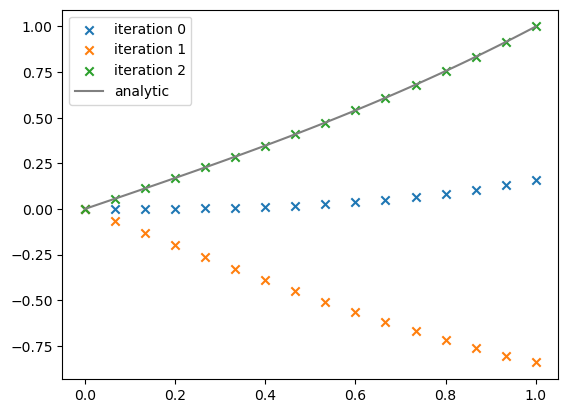

In [6]:
fig, ax = plt.subplots()

eta, y, z = solve_bvp(16, rhs, ax=ax)

x = np.linspace(0, 1, 100)
ax.plot(x, analytic(x), color="0.5", ls="-", label="analytic")
ax.legend()

Notice that we get the correct solution after only 2 iterations---this is mainly because this is a linear problem.

## Nonlinear example

Consider the problem:

$$u^{\prime\prime} + u^2 = -\sin(x) (1 - \sin(x))$$

on $[0, 1]$ with 

\begin{align*}
u(0) &= 0 \\
u(1) &= \sin(1)
\end{align*}

```{note}
This is nonlinear because the term $u^2$ appears in the equation.
```

This has the solution: $u(x) = \sin(x)$

Rewriting it in terms of $y = u$ and $z = u^\prime$, we have:

\begin{align*}
y' &= z \\
z' &= -y^2 - \sin(x) (1 - \sin(x))
\end{align*}

Here's the righthand side function for this new system

In [7]:
def rhs2(x, y, z):
    """ RHS function.  Here y = u, z = u'"""
    
    dydx = z
    dzdx = -y**2 - np.sin(x) * (1.0 - np.sin(x))

    return dydx, dzdx

and the analytic solution

In [8]:
def analytic2(x):
    """ analytic solution """
    return np.sin(x)

finished iter 2, error = 1.8466767840805172
finished iter 3, error = 0.12915051105171896
finished iter 4, error = 0.023858013890531087
finished iter 5, error = 0.00031404043908051616
finished iter 6, error = 6.497196603636414e-07
finished iter 7, error = 1.748051261871642e-11


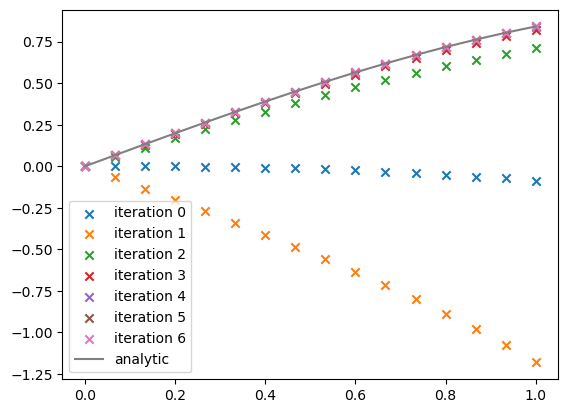

In [9]:
fig, ax = plt.subplots()

eta, y, z = solve_bvp(16, rhs2, ax=ax, y_right_true=np.sin(1))

x = np.linspace(0, 1, 100)
ax.plot(x, analytic2(x), color="0.5", ls="-", label="analytic")
ax.legend()

Now we see that it takes more iterations, but still converges.